In [1]:
import os
import numpy as np
import pandas as pd

# Drawing plots
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split


# Load helper functions
from mlutils.missing_data import *

In [2]:
# defaults

#  Uses all available CPU cores
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())

# Set the display option to show all rows and columns
pd.set_option('display.max_columns', None)  # To show all columns
pd.set_option('display.max_rows', None)     # To show all rows (optional)
pd.set_option('display.width', None)        # To avoid line truncation

graph_color = "cadetblue"
directory = "../datasets/original_BCCC-CIC-IDS-2017/subsets"
file = f"{directory}/original_only_http_https_attacks_port_80_and_443.csv"
df = pd.read_csv(file, low_memory=False)

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127922 entries, 0 to 1127921
Data columns (total 124 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    flow_id                     object 
 1    timestamp                   object 
 2    src_ip                      object 
 3    src_port                    int64  
 4    dst_ip                      object 
 5    dst_port                    int64  
 6    protocol                    object 
 7    duration                    float64
 8    packets_count               int64  
 9    fwd_packets_count           int64  
 10   bwd_packets_count           int64  
 11   total_payload_bytes         int64  
 12   fwd_total_payload_bytes     int64  
 13   bwd_total_payload_bytes     int64  
 14   payload_bytes_max           int64  
 15   payload_bytes_min           int64  
 16   payload_bytes_mean          float64
 17   payload_bytes_std           float64
 18   payload_bytes_variance      float64
 19 

In [4]:
pd.options.display.max_rows = 80

print('Overview of Columns:')
df.describe().transpose()

Overview of Columns:


,count,mean,std,min,25%,50%,75%,max
src_port,1127922.0,4.730114e+04,1.342801e+04,1028.0,41580.0,51221.000000,56010.000000,6.553500e+04
dst_port,1127922.0,2.467408e+02,1.808990e+02,80.0,80.0,80.000000,443.000000,4.430000e+02
duration,1127922.0,2.010459e+01,5.786774e+01,0.0,0.0,0.167992,6.168971,5.079142e+03
packets_count,1127922.0,4.119717e+01,5.890794e+03,1.0,1.0,12.000000,17.000000,2.466364e+06
fwd_packets_count,1127922.0,1.889506e+01,2.517349e+03,0.0,1.0,6.000000,10.000000,1.046340e+06
...,...,...,...,...,...,...,...,...
bwd_packets_IAT_total,1127922.0,7.012576e+07,3.165708e+08,0.0,0.0,0.151736,5.944876,1.499458e+09
subflow_fwd_packets,1127922.0,4.706287e+00,6.683763e+02,0.0,0.0,0.000000,3.000000,5.231700e+05
subflow_bwd_packets,1127922.0,5.351630e+00,8.929362e+02,0.0,0.0,0.000000,2.500000,7.058955e+05
subflow_fwd_bytes,1127922.0,1.885343e+02,2.300183e+03,0.0,0.0,0.000000,36.833333,1.214208e+06


In [5]:
dups = df[df.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 2323


In [6]:
df.drop_duplicates(inplace = True)
df.shape

(1125599, 124)

In [7]:
# Identifying missing values
missing_val = df.isna().sum()
print(missing_val.loc[missing_val > 0])

timestamp             1
timestamp_datetime    1
time_bin              1
dtype: int64


In [8]:
# Checking for infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [9]:
df['label'].unique()

array(['DoS_Slowloris', 'DoS_Hulk', 'DoS_Slowhttptest', 'DDoS_LOIT',
       'Benign', 'DoS_GoldenEye'], dtype=object)

In [10]:
# Types of attacks & normal instances (BENIGN)
df['label'].value_counts()

label
Benign              730257
DoS_Hulk            282855
DDoS_LOIT            94535
DoS_GoldenEye         7741
DoS_Slowhttptest      5537
DoS_Slowloris         4674
Name: count, dtype: int64

In [11]:

# Checking for columns with zero standard deviation (the blank squares in the heatmap)
std = df.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
zero_std_cols

['urg_flag_counts', 'fwd_urg_flag_counts', 'bwd_urg_flag_counts']

In [12]:
# Label encoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

In [13]:
corr = df.corr(numeric_only = True).round(2)

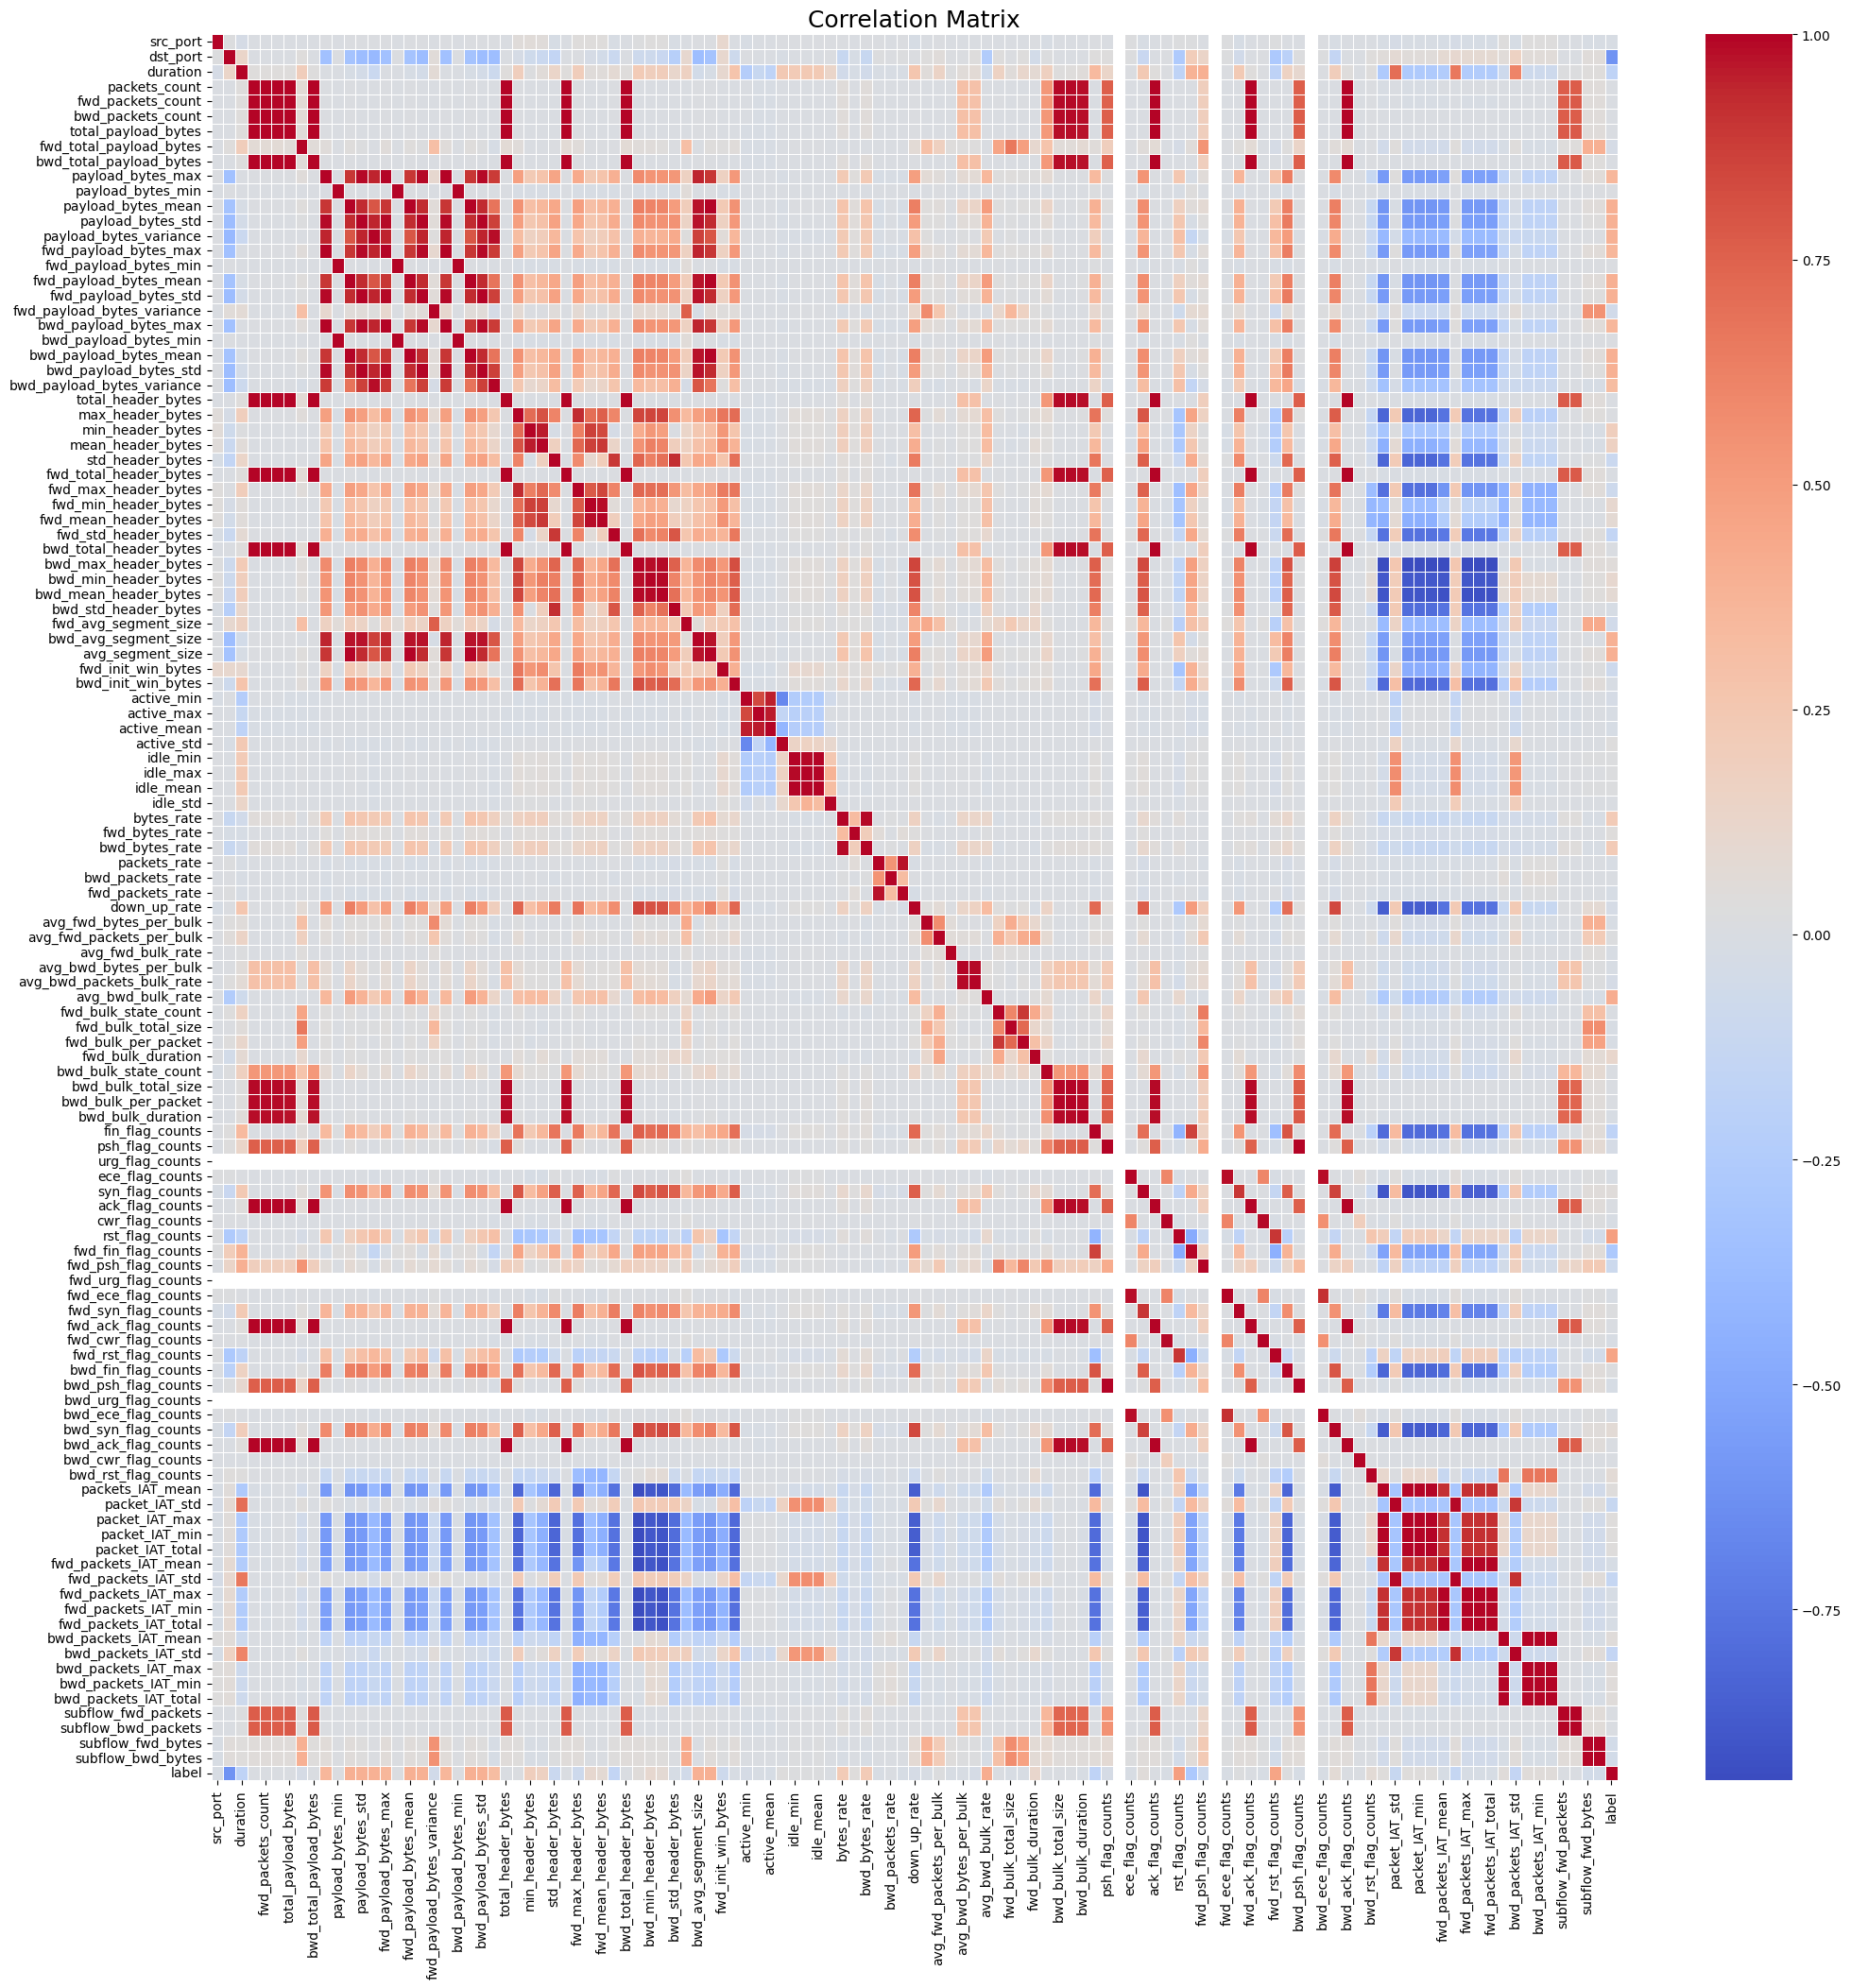

In [14]:
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

In [15]:
# Positive correlation features for 'Attack Number'
pos_corr_features = corr['label'][(corr['label'] > 0) & (corr['label'] < 1)].index.tolist()

print("Features with positive correlation with 'label':\n")
for i, feature in enumerate(pos_corr_features, start = 1):
    corr_value = corr.loc[feature, 'label']
    print('{:<3} {:<24} :{}'.format(f'{i}.', feature, corr_value))

Features with positive correlation with 'label':

1.  payload_bytes_max        :0.36
2.  payload_bytes_min        :0.01
3.  payload_bytes_mean       :0.4
4.  payload_bytes_std        :0.39
5.  payload_bytes_variance   :0.39
6.  fwd_payload_bytes_max    :0.36
7.  fwd_payload_bytes_min    :0.01
8.  fwd_payload_bytes_mean   :0.4
9.  fwd_payload_bytes_std    :0.39
10. bwd_payload_bytes_max    :0.36
11. bwd_payload_bytes_min    :0.01
12. bwd_payload_bytes_mean   :0.4
13. bwd_payload_bytes_std    :0.39
14. bwd_payload_bytes_variance :0.32
15. max_header_bytes         :0.01
16. min_header_bytes         :0.19
17. mean_header_bytes        :0.17
18. fwd_min_header_bytes     :0.1
19. fwd_mean_header_bytes    :0.08
20. bwd_max_header_bytes     :0.05
21. bwd_min_header_bytes     :0.1
22. bwd_mean_header_bytes    :0.08
23. bwd_avg_segment_size     :0.39
24. avg_segment_size         :0.4
25. active_std               :0.03
26. idle_min                 :0.02
27. idle_max                 :0.02
28. idle_

In [16]:
print(f'Number of considerable important features: {len(pos_corr_features)}')

Number of considerable important features: 49


/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_76520/237594026.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'label', data = attacks, palette = 'pastel', order = attacks['label'].value_counts().index)


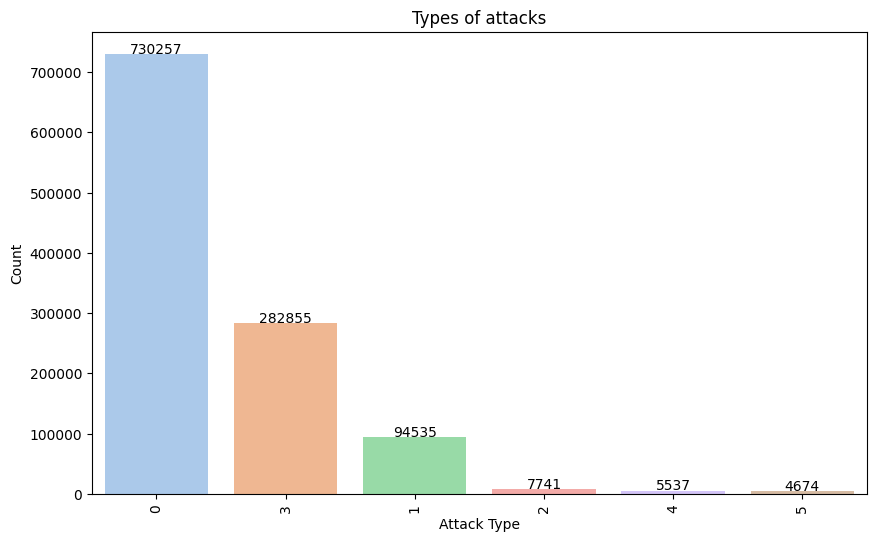

In [17]:
# Different 'Attack Type' in the main dataset excluding 'BENIGN'
attacks = df.loc[df['label'] != 'BENIGN']

plt.figure(figsize = (10, 6))
ax = sns.countplot(x = 'label', data = attacks, palette = 'pastel', order = attacks['label'].value_counts().index)
plt.title('Types of attacks')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation = 90)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height() + 1000), ha = 'center')

plt.show()

In [18]:
# For improving performance and reduce memory-related errors
old_memory_usage = df.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in df.columns:
    col_type = df[col].dtype
    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)

new_memory_usage = df.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")

Initial memory usage: 1073.45 MB
Final memory usage: 583.96 MB


In [19]:
# Calculating percentage reduction in memory usage
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Reduced memory usage: 45.60%


In [20]:
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1125599 entries, 0 to 1127921
Data columns (total 124 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    flow_id                     object 
 1    timestamp                   object 
 2    src_ip                      object 
 3    src_port                    int32  
 4    dst_ip                      object 
 5    dst_port                    int32  
 6    protocol                    object 
 7    duration                    float32
 8    packets_count               int32  
 9    fwd_packets_count           int32  
 10   bwd_packets_count           int32  
 11   total_payload_bytes         int64  
 12   fwd_total_payload_bytes     int32  
 13   bwd_total_payload_bytes     int64  
 14   payload_bytes_max           int32  
 15   payload_bytes_min           int32  
 16   payload_bytes_mean          float32
 17   payload_bytes_std           float32
 18   payload_bytes_variance      float32
 19   fwd

In [21]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
src_port,1125599.0,47302.002559,13436.638136,1028.0,41588.0,51226.000000,56014.000000,6.553500e+04
dst_port,1125599.0,246.931452,180.914445,80.0,80.0,80.000000,443.000000,4.430000e+02
duration,1125599.0,20.146082,57.920204,0.0,0.0,0.168994,6.186523,5.079143e+03
packets_count,1125599.0,41.280132,5896.869519,1.0,1.0,12.000000,17.000000,2.466364e+06
fwd_packets_count,1125599.0,18.931989,2519.945311,0.0,1.0,6.000000,10.000000,1.046340e+06
...,...,...,...,...,...,...,...,...
subflow_fwd_packets,1125599.0,4.715999,669.065613,0.0,0.0,0.000000,3.000000,5.231700e+05
subflow_bwd_packets,1125599.0,5.362674,893.857117,0.0,0.0,0.000000,2.500000,7.058955e+05
subflow_fwd_bytes,1125599.0,188.923386,2302.539795,0.0,0.0,0.000000,37.000000,1.214208e+06
subflow_bwd_bytes,1125599.0,188.923386,2302.539795,0.0,0.0,0.000000,37.000000,1.214208e+06


In [22]:
# Dropping columns with only one unique value
num_unique = df.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
df = df[not_one_variable]

print('Dropped columns:')
dropped_cols


Dropped columns:


Index(['urg_flag_counts', 'fwd_urg_flag_counts', 'bwd_urg_flag_counts'], dtype='object')

In [23]:
df.shape

(1125599, 121)

In [24]:
# Columns after removing non variant columns
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1125599 entries, 0 to 1127921
Data columns (total 121 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    flow_id                     object 
 1    timestamp                   object 
 2    src_ip                      object 
 3    src_port                    int32  
 4    dst_ip                      object 
 5    dst_port                    int32  
 6    protocol                    object 
 7    duration                    float32
 8    packets_count               int32  
 9    fwd_packets_count           int32  
 10   bwd_packets_count           int32  
 11   total_payload_bytes         int64  
 12   fwd_total_payload_bytes     int32  
 13   bwd_total_payload_bytes     int64  
 14   payload_bytes_max           int32  
 15   payload_bytes_min           int32  
 16   payload_bytes_mean          float32
 17   payload_bytes_std           float32
 18   payload_bytes_variance      float32
 19   fwd

In [25]:
# Delete features that creates noise
df = df.drop(['timestamp'],axis=1)
df = df.drop(['flow_id'],axis=1)
df = df.drop(['src_ip'],axis=1)
df = df.drop(['dst_ip'],axis=1)
df = df.drop(['dst_port'],axis=1)
df = df.drop(['src_port'],axis=1)
df = df.drop(['protocol'],axis=1)
df = df.drop(['timestamp_datetime'],axis=1)
df = df.drop(['time_bin'],axis=1)

In [26]:
df['label'].value_counts()

label
0    730257
3    282855
1     94535
2      7741
4      5537
5      4674
Name: count, dtype: int64

In [27]:
pd.set_option('display.max_columns', None)
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1125599 entries, 0 to 1127921
Data columns (total 112 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    duration                    float32
 1    packets_count               int32  
 2    fwd_packets_count           int32  
 3    bwd_packets_count           int32  
 4    total_payload_bytes         int64  
 5    fwd_total_payload_bytes     int32  
 6    bwd_total_payload_bytes     int64  
 7    payload_bytes_max           int32  
 8    payload_bytes_min           int32  
 9    payload_bytes_mean          float32
 10   payload_bytes_std           float32
 11   payload_bytes_variance      float32
 12   fwd_payload_bytes_max       int32  
 13   fwd_payload_bytes_min       int32  
 14   fwd_payload_bytes_mean      float32
 15   fwd_payload_bytes_std       float32
 16   fwd_payload_bytes_variance  float32
 17   bwd_payload_bytes_max       int32  
 18   bwd_payload_bytes_min       int32  
 19   bwd

In [28]:
# Split X and y
X = df.drop("label", axis=1)
y = df["label"]

## Feature selection using chi2

In [29]:
# Normalize Training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
column_names = X.columns.tolist()
X[column_names] = scaler.fit_transform(X[column_names])

In [30]:
X.head(10)

,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes
0,0.000109,0.000003,0.000004,0.000003,2.327127e-07,0.000056,1.574347e-07,0.01946,0.0,0.040432,0.03783,0.001431,0.01946,0.0,0.040432,0.03783,0.000198,0.01946,0.0,0.040432,0.03783,0.001455,0.000005,0.615385,0.666667,0.722222,0.199909,0.000006,0.666667,0.727273,0.664198,0.201218,0.000005,0.769231,0.727273,0.772727,0.333333,0.012447,0.031143,0.040432,0.445563,0.441901,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00007,0.000023,0.000075,0.000005,0.000007,0.000003,0.125529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.00004,0.0,0.166667,0.000003,0.0,0.0,0.04,0.000392,0.0,0.090909,0.000003,0.0,0.0,0.142857,0.00002,0.0,0.125,0.000003,0.0,0.0,5.254899e-11,0.001459,3.669627e-10,1.208424e-14,3.678429e-10,1.225252e-10,0.002293,3.670140e-10,1.532791e-13,3.675755e-10,1.225970e-10,0.000978,3.672274e-10,2.703054e-15,3.677909e-10,0.0,0.0,0.0,0.0
1,0.000108,0.000003,0.000004,0.000003,2.327127e-07,0.000056,1.574347e-07,0.01946,0.0,0.040432,0.03783,0.001431,0.01946,0.0,0.040432,0.03783,0.000198,0.01946,0.0,0.040432,0.03783,0.001455,0.000005,0.615385,0.666667,0.722222,0.199909,0.000006,0.666667,0.727273,0.664198,0.201218,0.000005,0.769231,0.727273,0.772727,0.333333,0.012447,0.031143,0.040432,0.445563,0.441901,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00007,0.000023,0.000076,0.000005,0.000007,0.000003,0.125529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.00004,0.0,0.166667,0.000003,0.0,0.0,0.04,0.000392,0.0,0.090909,0.000003,0.0,0.0,0.142857,0.00002,0.0,0.125,0.000003,0.0,0.0,5.246792e-11,0.001457,3.665652e-10,1.001720e-14,3.672754e-10,1.223204e-10,0.002291,3.666065e-10,2.703054e-15,3.669612e-10,1.224214e-10,0.000978,3.668787e-10,6.360128e-16,3.672641e-10,0.0,0.0,0.0,0.0
2,0.000108,0.000003,0.000004,0.000003,2.327127e-07,0.000056,1.574347e-07,0.01946,0.0,0.040432,0.03783,0.001431,0.01946,0.0,0.040432,0.03783,0.000198,0.01946,0.0,0.040432,0.03783,0.001455,0.000005,0.615385,0.666667,0.722222

In [31]:
y.head(10)

0    5
1    5
2    5
3    5
4    5
5    5
6    5
7    5
8    5
9    5
Name: label, dtype: int32

In [32]:
X.shape

(1125599, 111)

In [33]:
chi_scores, p_values = chi2(X,y)
p_values = pd.Series(p_values,index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


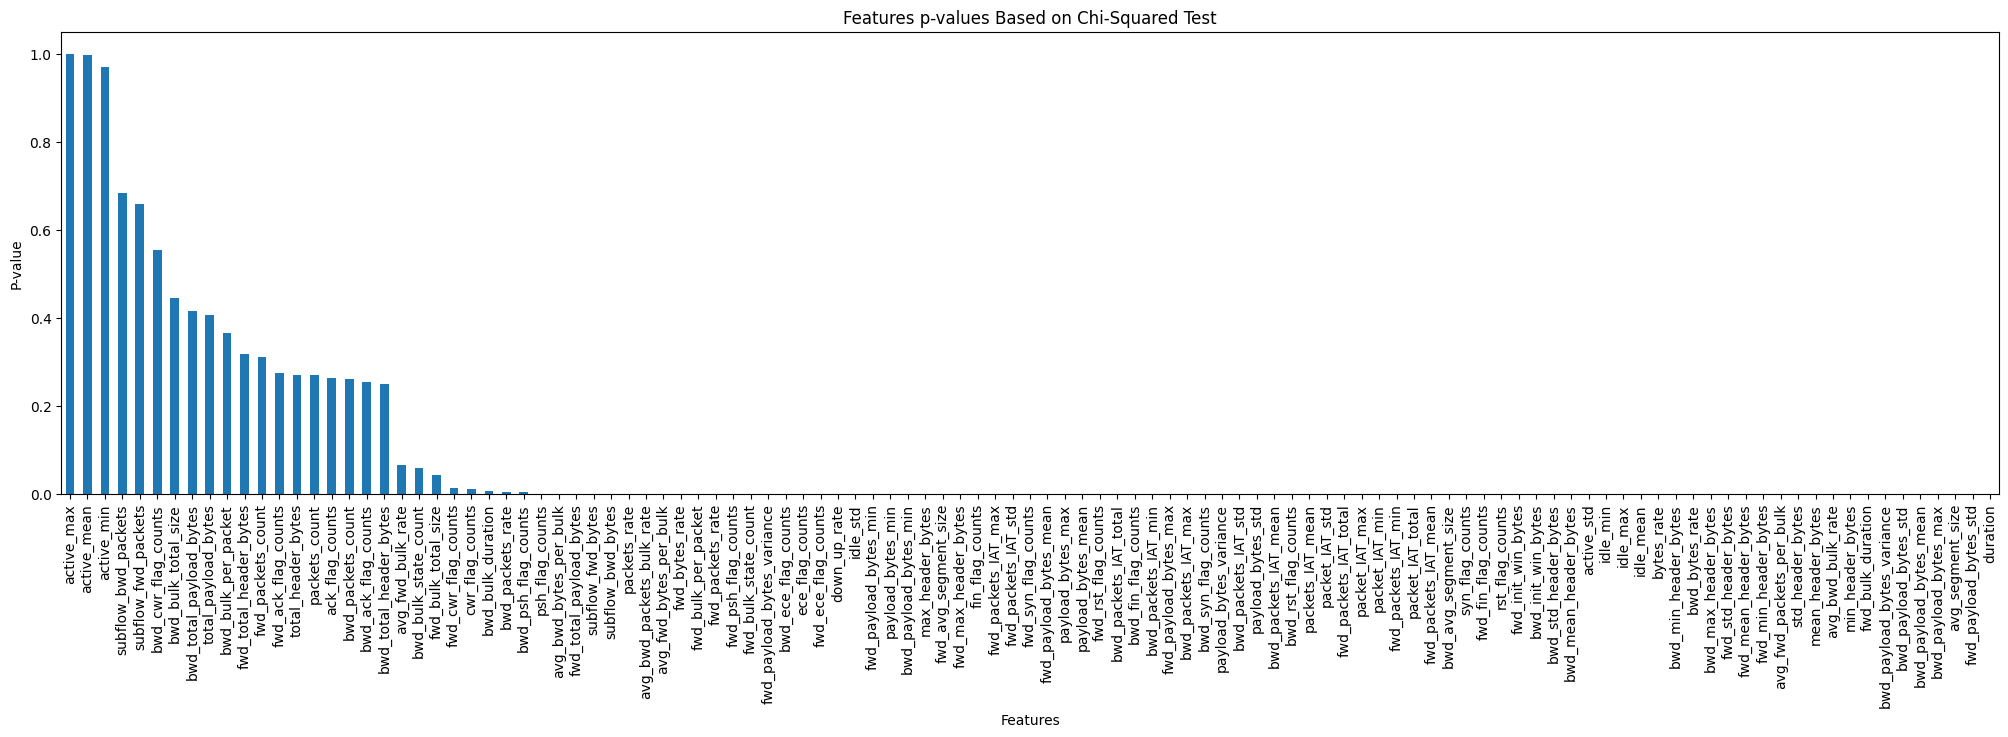

In [34]:
plt.figure(figsize=(25, 6))
p_values.plot(kind='bar')
plt.title('Features p-values Based on Chi-Squared Test')
plt.xlabel('Features')
plt.ylabel('P-value')
plt.show()
# Higher the p-value lower the importance

In [35]:
# Select features with p-value < 0.8
selected_features = np.where(p_values < 0.8)[0]

In [36]:
# Print results
print("Selected Feature Indices:", selected_features)

Selected Feature Indices: [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]


In [37]:
len(selected_features)

108

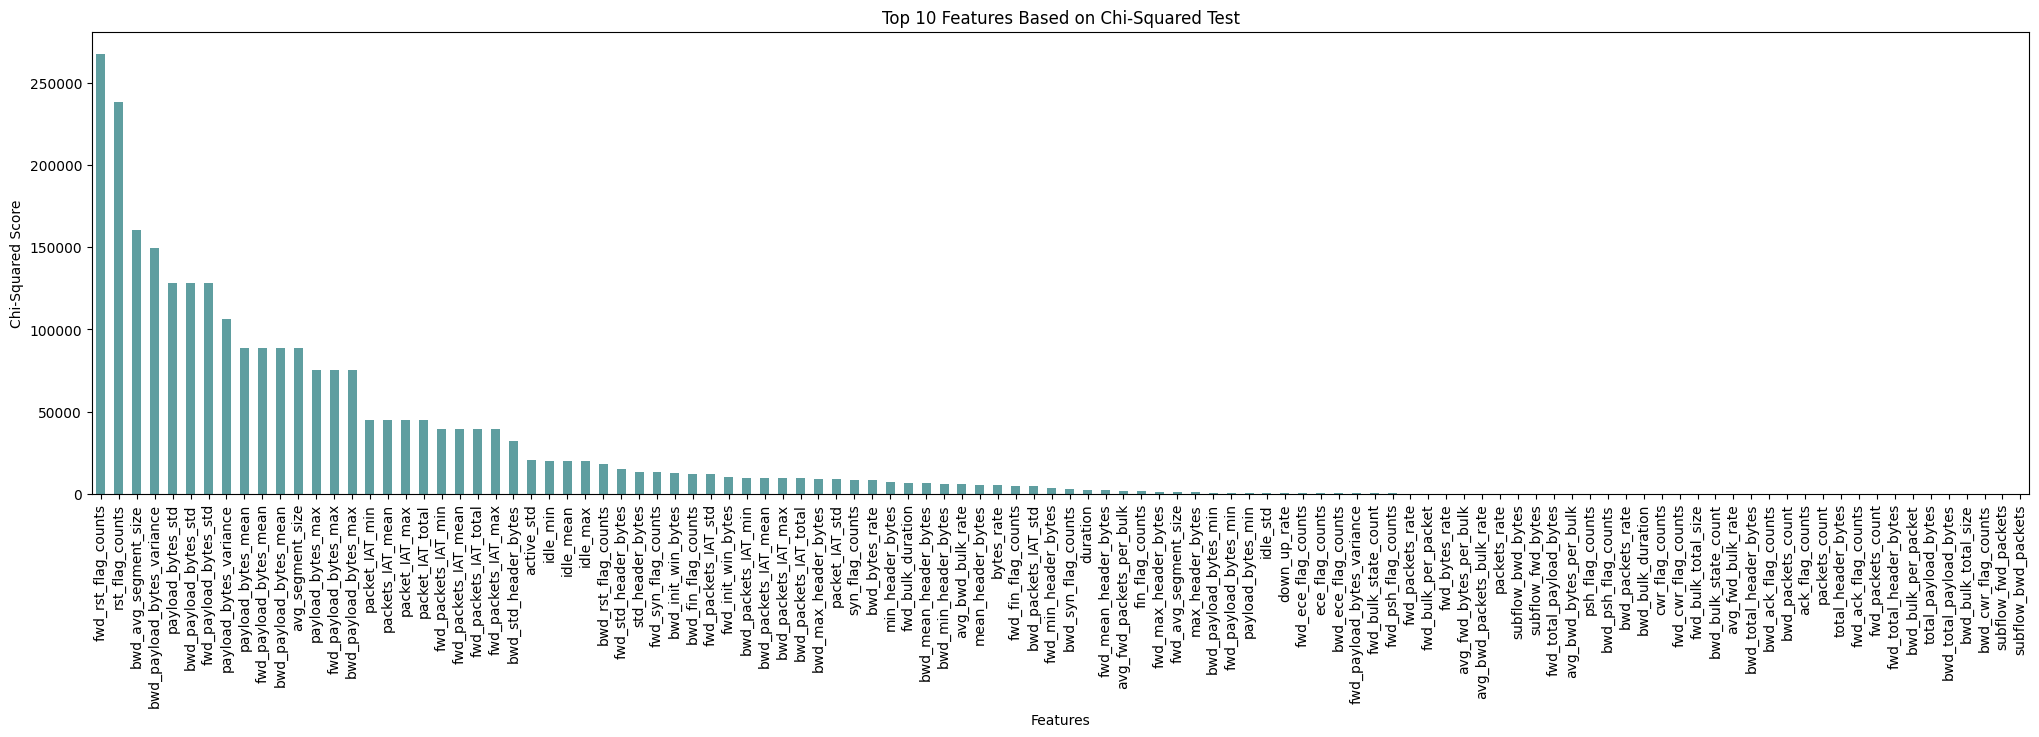

In [38]:
# Create a DataFrame for scores and p-values
chi2_scores = pd.Series(chi_scores, index=X.columns)

# Select the top 10 features based on chi-squared scores
top_features = chi2_scores.sort_values(ascending=False).head(len(selected_features))

# Plotting the bar plot
plt.figure(figsize=(25, 6))
top_features.plot(kind='bar', color=graph_color)
plt.title('Top 10 Features Based on Chi-Squared Test')
plt.xlabel('Features')
plt.ylabel('Chi-Squared Score')
plt.show()

In [39]:
top_features_plus_label = list(top_features.index)
top_features_plus_label.append('label')
print(top_features_plus_label)

['fwd_rst_flag_counts', 'rst_flag_counts', 'bwd_avg_segment_size', 'bwd_payload_bytes_variance', 'payload_bytes_std', 'bwd_payload_bytes_std', 'fwd_payload_bytes_std', 'payload_bytes_variance', 'payload_bytes_mean', 'fwd_payload_bytes_mean', 'bwd_payload_bytes_mean', 'avg_segment_size', 'payload_bytes_max', 'fwd_payload_bytes_max', 'bwd_payload_bytes_max', 'packet_IAT_min', 'packets_IAT_mean', 'packet_IAT_max', 'packet_IAT_total', 'fwd_packets_IAT_min', 'fwd_packets_IAT_mean', 'fwd_packets_IAT_total', 'fwd_packets_IAT_max', 'bwd_std_header_bytes', 'active_std', 'idle_min', 'idle_mean', 'idle_max', 'bwd_rst_flag_counts', 'fwd_std_header_bytes', 'std_header_bytes', 'fwd_syn_flag_counts', 'bwd_init_win_bytes', 'bwd_fin_flag_counts', 'fwd_packets_IAT_std', 'fwd_init_win_bytes', 'bwd_packets_IAT_min', 'bwd_packets_IAT_mean', 'bwd_packets_IAT_max', 'bwd_packets_IAT_total', 'bwd_max_header_bytes', 'packet_IAT_std', 'syn_flag_counts', 'bwd_bytes_rate', 'min_header_bytes', 'fwd_bulk_duration', 

# Create Train and test dataset with the proper features

In [40]:
X = df.drop("label", axis=1)
y = df["label"]

In [41]:
# Split dataset 50% training and 50% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [42]:
df_train = pd.concat([X_train, y_train], axis=1)  # Merging along columns

In [43]:
# Keep top features from chi-2 + label
df_train = df_train[top_features_plus_label]

In [44]:
print(df_train.dtypes)

fwd_rst_flag_counts             int32
rst_flag_counts                 int32
bwd_avg_segment_size          float32
bwd_payload_bytes_variance    float32
payload_bytes_std             float32
                               ...   
bwd_bulk_total_size             int64
bwd_cwr_flag_counts             int32
subflow_fwd_packets           float32
subflow_bwd_packets           float32
label                           int32
Length: 109, dtype: object


In [45]:
df_train['label'].value_counts()

label
0    364851
3    141650
1     47357
2      3810
4      2740
5      2391
Name: count, dtype: int64

In [46]:
df_train['label'].value_counts(normalize = True)

label
0    0.648279
3    0.251688
1    0.084145
2    0.006770
4    0.004869
5    0.004248
Name: proportion, dtype: float64

In [47]:
# Count the number of 'Benign' samples
benign_count = (df_train['label'] == 0).sum()

# Count the number of attack samples (anything not 'Benign')
attack_count = len(df_train) - benign_count

# Calculate number of feature
num_features = df_train.shape[1] - ('label' in df_train.columns)

In [48]:
print(f"Total samples: {len(df_train):,}")
print(f"Benign samples: {benign_count:,}")
print(f"Attack samples: {attack_count:,}")
print("Number of features:", num_features)

Total samples: 562,799
Benign samples: 364,851
Attack samples: 197,948
Number of features: 108


In [49]:
df_train.head(10)

,fwd_rst_flag_counts,rst_flag_counts,bwd_avg_segment_size,bwd_payload_bytes_variance,payload_bytes_std,bwd_payload_bytes_std,fwd_payload_bytes_std,payload_bytes_variance,payload_bytes_mean,fwd_payload_bytes_mean,bwd_payload_bytes_mean,avg_segment_size,payload_bytes_max,fwd_payload_bytes_max,bwd_payload_bytes_max,packet_IAT_min,packets_IAT_mean,packet_IAT_max,packet_IAT_total,fwd_packets_IAT_min,fwd_packets_IAT_mean,fwd_packets_IAT_total,fwd_packets_IAT_max,bwd_std_header_bytes,active_std,idle_min,idle_mean,idle_max,bwd_rst_flag_counts,fwd_std_header_bytes,std_header_bytes,fwd_syn_flag_counts,bwd_init_win_bytes,bwd_fin_flag_counts,fwd_packets_IAT_std,fwd_init_win_bytes,bwd_packets_IAT_min,bwd_packets_IAT_mean,bwd_packets_IAT_max,bwd_packets_IAT_total,bwd_max_header_bytes,packet_IAT_std,syn_flag_counts,bwd_bytes_rate,min_header_bytes,fwd_bulk_duration,bwd_mean_header_bytes,bwd_min_header_bytes,avg_bwd_bulk_rate,mean_header_bytes,bytes_rate,fwd_fin_flag_counts,bwd_packets_IAT_std,fwd_min_header_bytes,bwd_syn_flag_counts,duration,fwd_mean_header_bytes,avg_fwd_packets_per_bulk,fin_flag_counts,fwd_max_header_bytes,fwd_avg_segment_size,max_header_bytes,bwd_payload_bytes_min,fwd_payload_bytes_min,payload_bytes_min,idle_std,down_up_rate,fwd_ece_flag_counts,ece_flag_counts,bwd_ece_flag_counts,fwd_payload_bytes_variance,fwd_bulk_state_count,fwd_psh_flag_counts,fwd_packets_rate,fwd_bulk_per_packet,fwd_bytes_rate,avg_fwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,packets_rate,subflow_bwd_bytes,subflow_fwd_bytes,fwd_total_payload_bytes,avg_bwd_bytes_per_bulk,psh_flag_counts,bwd_psh_flag_counts,bwd_packets_rate,bwd_bulk_duration,cwr_flag_counts,fwd_cwr_flag_counts,fwd_bulk_total_size,bwd_bulk_state_count,avg_fwd_bulk_rate,bwd_total_header_bytes,bwd_ack_flag_counts,bwd_packets_count,ack_flag_counts,packets_count,total_header_bytes,fwd_ack_flag_counts,fwd_packets_count,fwd_total_header_bytes,bwd_bulk_per_packet,total_payload_bytes,bwd_total_payload_bytes,bwd_bulk_total_size,bwd_cwr_flag_counts,subflow_fwd_packets,subflow_bwd_packets,label
756394,0,0,341.399994,4.662158e+05,489.519440,489.519440,489.519440,2.396293e+05,182.000000,182.000000,182.000000,182.000000,1707,1707,1707,6.604195e-05,1.633245e+00,9.997216e+00,1.633245e+01,4.573107e-03,3.243519e+00,1.621760e+01,9.997216e+00,3.200000,0.0,0.0,0.0,0.0,0,4.472136,3.950102,1,65535,1,4.076236,8192,0.010054,4.054319,10.112096,16.217276,28,3.281332,2,1.045158e+02,20,0.0,21.600000,20,0.0,21.818182,1.225780e+02,1,4.249335,20,1,16.332453,22.000000,0.0,2,32,49.166668,32,0,0,0,0.0,0.833333,0,0,0,11988.805664,0,1,0.367367,0,18.062199,0.0,0.0,0.673506,147.50000,147.50000,295,0.0,2,1,0.306139,0.000000,0,0,0,0,0.0,108,5,5,10,11,240,5,6,132,0,2002,1707,0,0,3.000000,2.500000,0
431449,1,1,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0,0,0,1.499434e+09,1.499434e+09,1.499434e+09,1.499434e+09,1.499434e+09,1.499434e+09,1.499434e+09,1.499434e+09,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0.000000,0,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000e+00,20,0.0,0.000000,0,0.0,20.000000,0.000000e+00,0,0.000000,20,0,0.000000,20.000000,0.0,0,20,0.000000,20,0,0,0,0.0,0.000000,0,0,0,0.000000,0,0,0.000000,0,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0,0.0,0,0,0.000000,0.000000,0,0,0,0,0.0,0,0,0,1,1,20,1,1,20,0,0,0,0,0,0.000000,0.000000,0
256516,1,1,2319.000000,1.563390e+07,2788.017090,2788.017090,2788.017090,7.773040e+06,996.333313,996.333313,996.333313,996.333313,10147,10147,10147,3.099442e-06,5.579000e-04,3.430843e-03,6.136894e-03,3.099442e-06,1.022820e-03,6.136894e-03,4.124880e-03,3.200000,0.0,0.0,0.0,0.0,0,2.799417,2.981424,1,28960,1,0.001485,29200,0.000004,0.000570,0.001682,0.002280,40,0.001000,2,1.889392e+06,32,0.0,33.599998,32,0.0,33.333332,1.948217e+06,0,0.000657,32,1,0.006137,33.142857,0.0,1,40,51.571430,40,0,0,0,0.0,0.714286,0,0,0,15957.673828,0,1,1140.642090,0,58824.542969,0.0,0.0,1955.386475,0.00000,0.00000,361,0.0,2,1,814.744385,0.000000,0,0,0,0

In [ ]:
# Saving the DataFrame to a CSV file
df_train.to_csv(f'{directory}/training_and_val_dataset_without_normalization.csv', index=False)  # index=False prevents writing row numbers

## Test dataset

In [50]:
# Keep top features
top_features_without_label = list(top_features.index)
X_test = X_test[top_features_without_label]

In [52]:
# Save test dataset without normalization
df_test_wo_norm = pd.concat([X_test, y_test], axis=1)  # Merging along columns
df_test_wo_norm.to_csv(f'{directory}/test_dataset_without_normalization.csv', index=False)  # index=False prevents writing row numbers

In [53]:
# Normalize test dataset
X_test[top_features_without_label] = scaler.fit_transform(X_test[top_features_without_label])

In [54]:
df_test = pd.concat([X_test, y_test], axis=1)  # Merging along columns

In [55]:
df_test['label'].value_counts(normalize = True)

label
0    0.649264
3    0.250897
1    0.083827
2    0.006985
4    0.004970
5    0.004057
Name: proportion, dtype: float64

In [56]:
df_test['label'].value_counts()

label
0    365406
3    141205
1     47178
2      3931
4      2797
5      2283
Name: count, dtype: int64

In [57]:
# Count the number of 'Benign' samples
benign_count = (df_test['label'] == 0).sum()

# Count the number of attack samples (anything not 'Benign')
attack_count = len(df_test) - benign_count

# Calculate number of feature
num_features = df_test.shape[1] - ('label' in df_test.columns)

In [58]:
print(f"Total samples: {len(df_test):,}")
print(f"Benign samples: {benign_count:,}")
print(f"Attack samples: {attack_count:,}")
print("Number of features:", num_features)

Total samples: 562,800
Benign samples: 365,406
Attack samples: 197,394
Number of features: 108


In [59]:
df_test.head(10)

,fwd_rst_flag_counts,rst_flag_counts,bwd_avg_segment_size,bwd_payload_bytes_variance,payload_bytes_std,bwd_payload_bytes_std,fwd_payload_bytes_std,payload_bytes_variance,payload_bytes_mean,fwd_payload_bytes_mean,bwd_payload_bytes_mean,avg_segment_size,payload_bytes_max,fwd_payload_bytes_max,bwd_payload_bytes_max,packet_IAT_min,packets_IAT_mean,packet_IAT_max,packet_IAT_total,fwd_packets_IAT_min,fwd_packets_IAT_mean,fwd_packets_IAT_total,fwd_packets_IAT_max,bwd_std_header_bytes,active_std,idle_min,idle_mean,idle_max,bwd_rst_flag_counts,fwd_std_header_bytes,std_header_bytes,fwd_syn_flag_counts,bwd_init_win_bytes,bwd_fin_flag_counts,fwd_packets_IAT_std,fwd_init_win_bytes,bwd_packets_IAT_min,bwd_packets_IAT_mean,bwd_packets_IAT_max,bwd_packets_IAT_total,bwd_max_header_bytes,packet_IAT_std,syn_flag_counts,bwd_bytes_rate,min_header_bytes,fwd_bulk_duration,bwd_mean_header_bytes,bwd_min_header_bytes,avg_bwd_bulk_rate,mean_header_bytes,bytes_rate,fwd_fin_flag_counts,bwd_packets_IAT_std,fwd_min_header_bytes,bwd_syn_flag_counts,duration,fwd_mean_header_bytes,avg_fwd_packets_per_bulk,fin_flag_counts,fwd_max_header_bytes,fwd_avg_segment_size,max_header_bytes,bwd_payload_bytes_min,fwd_payload_bytes_min,payload_bytes_min,idle_std,down_up_rate,fwd_ece_flag_counts,ece_flag_counts,bwd_ece_flag_counts,fwd_payload_bytes_variance,fwd_bulk_state_count,fwd_psh_flag_counts,fwd_packets_rate,fwd_bulk_per_packet,fwd_bytes_rate,avg_fwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,packets_rate,subflow_bwd_bytes,subflow_fwd_bytes,fwd_total_payload_bytes,avg_bwd_bytes_per_bulk,psh_flag_counts,bwd_psh_flag_counts,bwd_packets_rate,bwd_bulk_duration,cwr_flag_counts,fwd_cwr_flag_counts,fwd_bulk_total_size,bwd_bulk_state_count,avg_fwd_bulk_rate,bwd_total_header_bytes,bwd_ack_flag_counts,bwd_packets_count,ack_flag_counts,packets_count,total_header_bytes,fwd_ack_flag_counts,fwd_packets_count,fwd_total_header_bytes,bwd_bulk_per_packet,total_payload_bytes,bwd_total_payload_bytes,bwd_bulk_total_size,bwd_cwr_flag_counts,subflow_fwd_packets,subflow_bwd_packets,label
317176,1.0,1.0,0.598091,0.268309,0.473906,0.473906,0.473906,0.224587,0.427452,0.427452,0.427452,0.427452,0.235294,0.235294,0.235294,1.001720e-14,9.499340e-11,8.875269e-10,1.139921e-09,6.360128e-16,1.628458e-10,1.139921e-09,8.960512e-10,0.461880,0.0,0.0,0.0,0.0,0.0,0.230524,0.297578,0.090909,0.445563,0.142857,0.004163,0.125002,1.272026e-15,2.220192e-10,8.875269e-10,8.880769e-10,0.615385,0.003702,0.166667,0.000585,0.333333,0.0,0.509091,0.454545,0.000000,0.384615,0.000367,0.00,0.005093,0.454545,0.125,0.000374,0.428628,0.0,0.04,0.533333,0.000539,0.461538,0.0,0.0,0.0,0.0,0.104167,0.0,0.0,0.0,8.657190e-07,0.0,0.000392,2.231779e-06,0.0,6.316355e-07,0.0,0.000000,2.417760e-06,0.000016,0.000016,0.000005,0.000000,0.000040,0.00002,2.789724e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000004,0.000004,0.000004,4.865464e-06,0.000005,5.308097e-06,6.689992e-06,7.645698e-06,7.762215e-06,0.000000,3.785656e-06,3.779410e-06,0.000000,0.0,0.000015,0.000007,1
553110,0.0,0.0,0.018441,0.000628,0.034423,0.034423,0.034423,0.001185,0.040666,0.040666,0.040666,0.040666,0.019541,0.019541,0.019541,1.144823e-14,4.896958e-10,6.528584e-09,7.345437e-09,1.081222e-13,1.049348e-09,7.345437e-09,6.528584e-09,0.254588,0.0,0.0,0.0,0.0,0.0,0.230524,0.232444,0.090909,0.066835,0.142857,0.030096,0.125002,2.067042e-15,1.098309e-10,6.674059e-10,7.688165e-10,0.538462,0.024204,0.166667,0.000004,0.333333,0.0,0.477273,0.454545,0.000000,0.368056,0.000007,0.04,0.003029,0.454545,0.125,0.002413,0.428628,0.0,0.08,0.533333,0.021244,0.461538,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,5.323331e-04,0.0,0.001176,3.463445e-07,0.0,3.862067e-06,0.0,0.000000,4.617926e-07,0.000649,0.000649,0.000193,0.000000,0.000099,0.00004,6.926889e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000006,0.000006,0.000006,6.081830e-06,0.000006,6.417251e-06,6.689992e-06,7.645698e-06,7.762215e-06,0.000000,4.432624e-07,1.864444e-07,0.000000,0.0,0.000015,0.000011,0
878048,0.0,0.0,0.345352,0.033181,0.226074,0.226074,0.2

In [ ]:
# Saving the DataFrame to a CSV file
df_test.to_csv(f'{directory}/test_dataset_with_normalization.csv', index=False)  # index=False prevents writing row numbers